## LSTM class Developed
-----------------------------
[feat] 7/16
- ! to prevent overfitting use K-fold, validation split ! <- NEED TO DEVELOP
- basical LSTM model => lstm dense need to doubled
- not tested
- without AOC, interest rate
- bidirectional LSTM Model

[feat] 7/17

[need] 7/17
- val_loss 범위 설정
- k-fold 구현-> LSTM 구조상 폐기
- return값 설정
- 모델 예측 설정 방법

[feat] 7/19 V 1.0
- postscale...      (done)
- model test res... (done)
- predict range .. (done) (using loss mean square err)

[need] 7/19 V 1.0
- prediction res return function => ??input??
-

[feat] 7/19 V 1.0.1
- visiualization update
- check res (Request)



imorts & get datas
------------

In [1]:
#!pip install -U finance-datareader

#%pip install FinanceDataReader

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense ,LSTM, Dropout,Bidirectional
from sklearn.model_selection import train_test_split, KFold
from tensorflow import expand_dims
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from os.path import join
from tensorflow import constant
from time import sleep
#import FinanceDataReader as fdr

In [3]:
data=pd.read_csv('/content/drive/MyDrive/2023_1st_vac/KRX_DATA/train.csv')

In [4]:
# prescaler
def getAOC(data):
  AOC = []
  close = data['종가']
  close_pre = close.shift(1)

  AOC.append(0)

  # aoc = (금일 종가 - 전일 종가) / 전일 종가
  for i in range(1, len(close)):
    aoc_value = ((close[i] - close_pre[i]) / close_pre[i]) * 100
    AOC.append(aoc_value)

  return AOC

#sort data by "종목명"
subject_Data=data.sort_values(by="종목명",inplace=False)
subject_Data.head()
subject_Data.columns

pv_s_data=pd.pivot_table(subject_Data,values=['거래량', '시가', '고가', '저가', '종가'],index=['종목코드','일자'])

divided = pv_s_data.index.get_level_values('종목코드').unique()

sliced_dataframes = []

for i in divided:
    sliced_data = pv_s_data.loc[i]
    sliced_dataframe = sliced_data.reset_index()
    sliced_dataframes.append(sliced_dataframe)

## LSTM Obj

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense ,LSTM, Dropout,Bidirectional
from sklearn.model_selection import train_test_split, KFold
from tensorflow import expand_dims
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from os.path import join
from tensorflow import constant
#import FinanceDataReader as fdr

class LSTM_Object():

  def __init__(self,data):
    #get sliced data
    self.data=data

  def modeling(self):

    self.prescale()
    self.model=Sequential()
    #layers
    self.model.add(Bidirectional(LSTM(1024,return_sequences=True,input_shape=(self.time_steps, self.num_features))))
    #self.model.add(LSTM(1024,return_sequences=True,input_shape=(self.x_train.shape[1], self.x_train.shape[2])))
    #self.model.add(Dropout(0.25))
    #self.model.add(LSTM(1024,return_sequences=True,input_shape=(self.x_train.shape[1], self.x_train.shape[2])))
    #self.model.add(LSTM(1024,return_sequences=True,input_shape=(self.x_train.shape[1], self.x_train.shape[2])))
    #self.model.add(Dropout(0.25))
    self.model.add(Dense(512, activation='relu'))
    self.model.add(Dense(256, activation='relu'))
    self.model.add(Dense(128, activation='relu'))
    #self.model.add(LSTM(1024,return_sequences=True,input_shape=(self.x_train.shape[1], self.x_train.shape[2])))
    #output layer
    self.model.add(Dense(1, activation='relu'))

    self.filename = join('/content/drive/MyDrive/2023_1st_vac/KRX_modelings/tests', 'ckeckpointer.ckpt')
    checkpoint = ModelCheckpoint(self.filename, save_weights_only=True, save_best_only=True,monitor='val_loss',verbose=0)

    earlystopping = EarlyStopping(monitor='val_loss', patience=100)
    self.model.compile(loss = 'mean_squared_error', optimizer=Adam(learning_rate=0.001))
    self.history=self.model.fit(self.x_train,self.y_train,epochs=1000,batch_size=128,validation_data=(self.x_val,self.x_val),shuffle=False,callbacks=[checkpoint, earlystopping],verbose=0)


  def prescale(self):
    x_scaler = MinMaxScaler()
    self.y_scaler = MinMaxScaler()
    # Scaling features
    x_data = self.data[['거래량', '고가', '시가', '저가']]
    x_data = x_scaler.fit_transform(x_data)
    # Scaling target variable (종가)
    y_data = self.data['종가']
    y_data = self.y_scaler.fit_transform(y_data.values.reshape(-1, 1))
    # validation set
    x_train_p, x_test, y_train_p, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
    x_train, x_val, y_train, y_val = train_test_split(x_train_p, y_train_p, test_size=0.25, shuffle=False)
    ### reshape input datas()


    self.num_features = x_data.shape[1]
    self.num_samples=x_data.shape[0]
    self.time_steps=30

    self.x_train = self.create_sequences(x_train)
    self.x_test = self.create_sequences(x_test)
    self.x_val = self.create_sequences(x_val)

    self.y_train=self.create_sequences(y_train)
    self.y_test=self.create_sequences(y_test)
    self.y_val=self.create_sequences(y_val)


  def create_sequences(self, data):
    num_samples, num_features = data.shape
    sequences = []
    for i in range(num_samples - self.time_steps +1):
      sequences.append(data[i:i + self.time_steps, :])
    return np.array(sequences)

  def create_sequences_y(self, data):
    num_samples, num_features = data.shape
    sequences = []
    for i in range(num_samples - self.time_steps +1):
      sequences.append(data[i:i + self.time_steps, :])
    return np.array(sequences)

  def inverse_sequences(self,data_sequences):
    num_samples, num_steps, num_features = data_sequences.shape
    data = np.zeros((num_samples + self.time_steps - 1, num_features))
    for i in range(num_samples):
      data[i:i + self.time_steps, :] += data_sequences[i, :, :]
    data /= self.time_steps
    return data[:num_samples]
    #frquency domain inverse laplace transform

  def ret_learning(self):
    # rescale to get real value
    self.prescale()
    self.modeling()
    sleep(0.5)
    self.model.load_weights(self.filename)
    pred = self.model.predict(self.x_test)
    sleep(0.5)

    rescaled_pred = self.y_scaler.inverse_transform(self.inverse_sequences(pred).reshape(-1,1))
    rescaled_real = self.y_scaler.inverse_transform(self.inverse_sequences(self.y_test).reshape(-1,1))
    sleep(0.5)

    #real-pred to get resonable value (later)
    #k=0
    #for i in rescaled_pred:
    #  print("predict: {}, real: {}".format(i,rescaled_real[k]))
    #  k+=1

    plt.figure(figsize=(12, 9))
    plt.plot(rescaled_real, label='actual')
    plt.plot(rescaled_pred, label='prediction')
    plt.legend()
    plt.show()

In [6]:
labels=data[['종목코드']]


종목코드    A060310
Name: 0, dtype: object
3/3 [==============================] - 1s 18ms/step


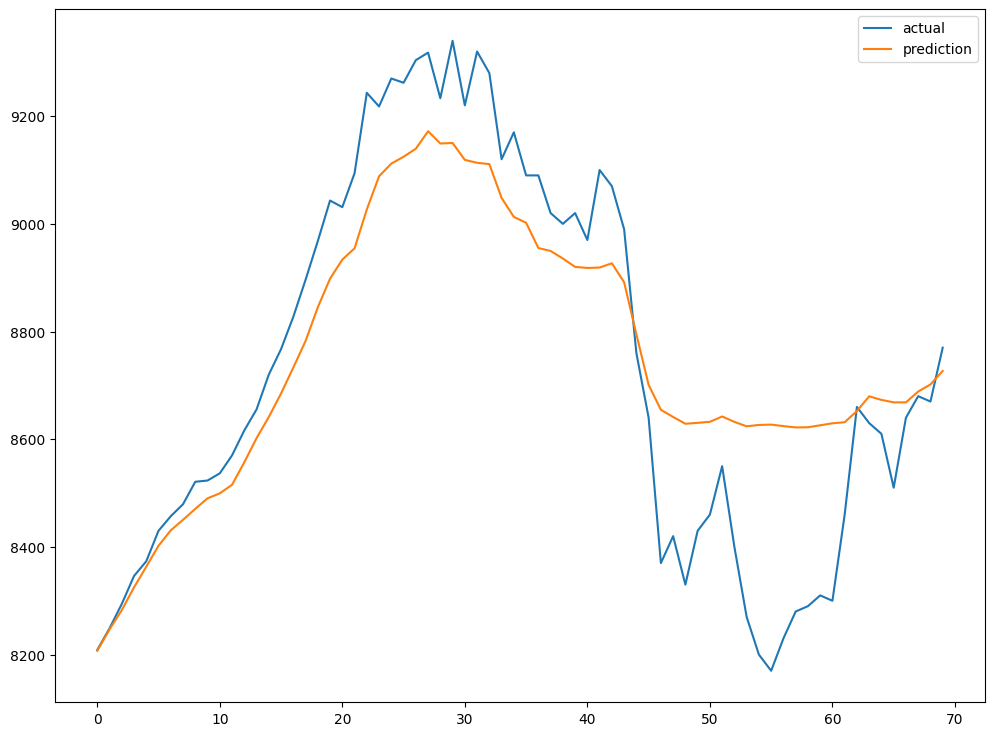

종목코드    A095570
Name: 1, dtype: object
3/3 [==============================] - 1s 13ms/step


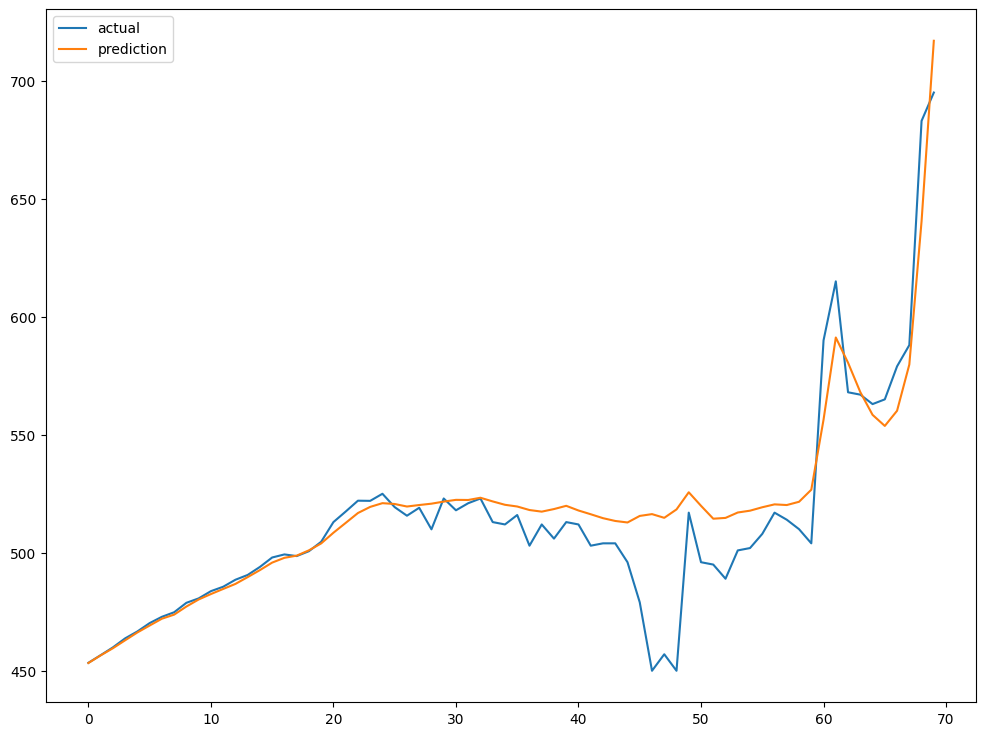

종목코드    A006840
Name: 2, dtype: object
3/3 [==============================] - 1s 24ms/step


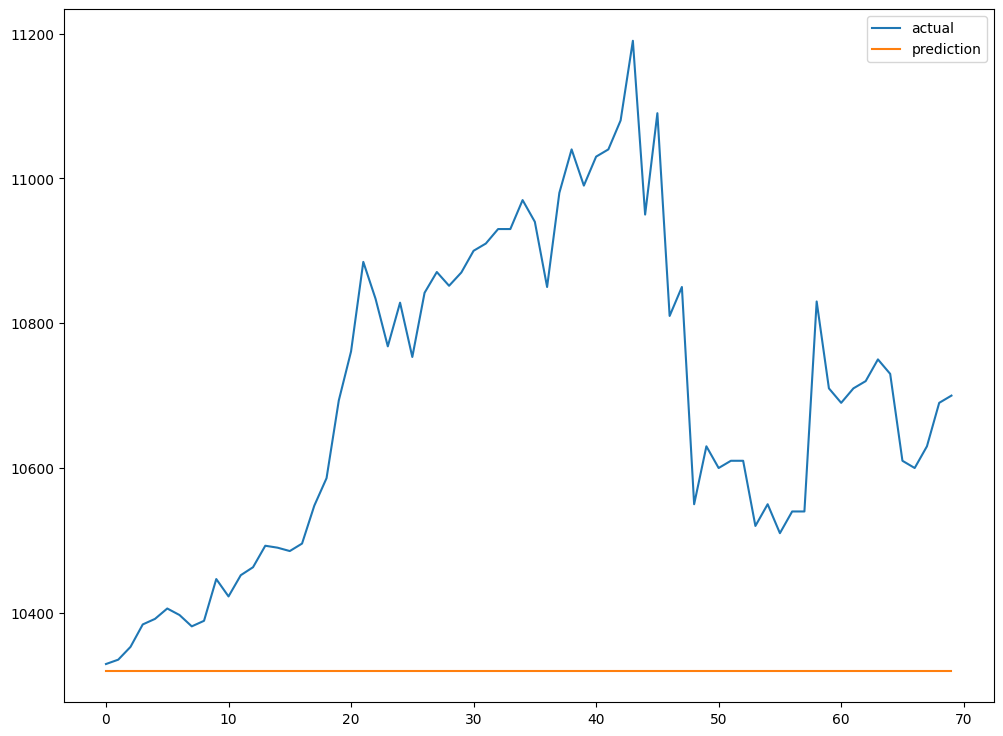

종목코드    A054620
Name: 3, dtype: object
3/3 [==============================] - 1s 14ms/step


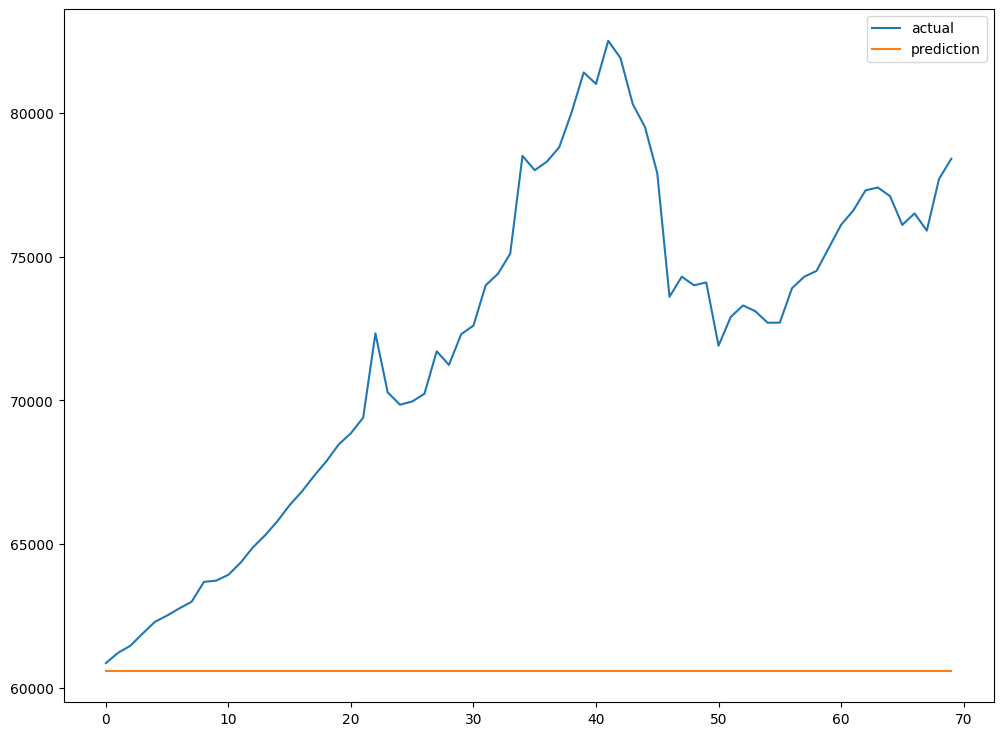

종목코드    A265520
Name: 4, dtype: object


3/3 [==============================] - 1s 13ms/step


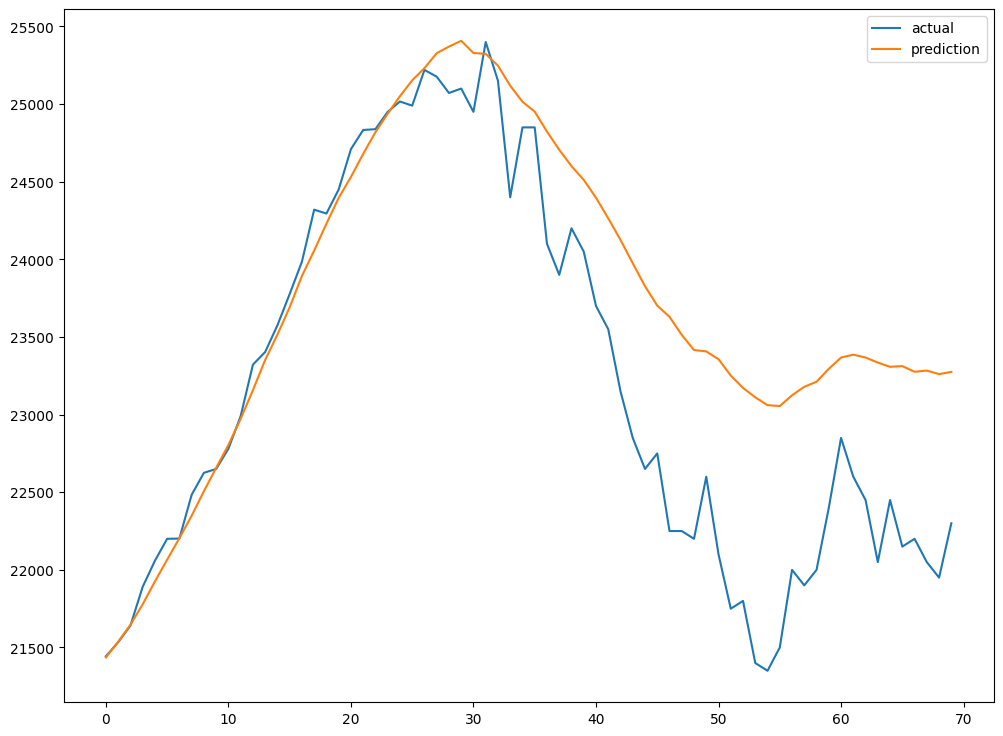

종목코드    A211270
Name: 5, dtype: object


3/3 [==============================] - 1s 22ms/step


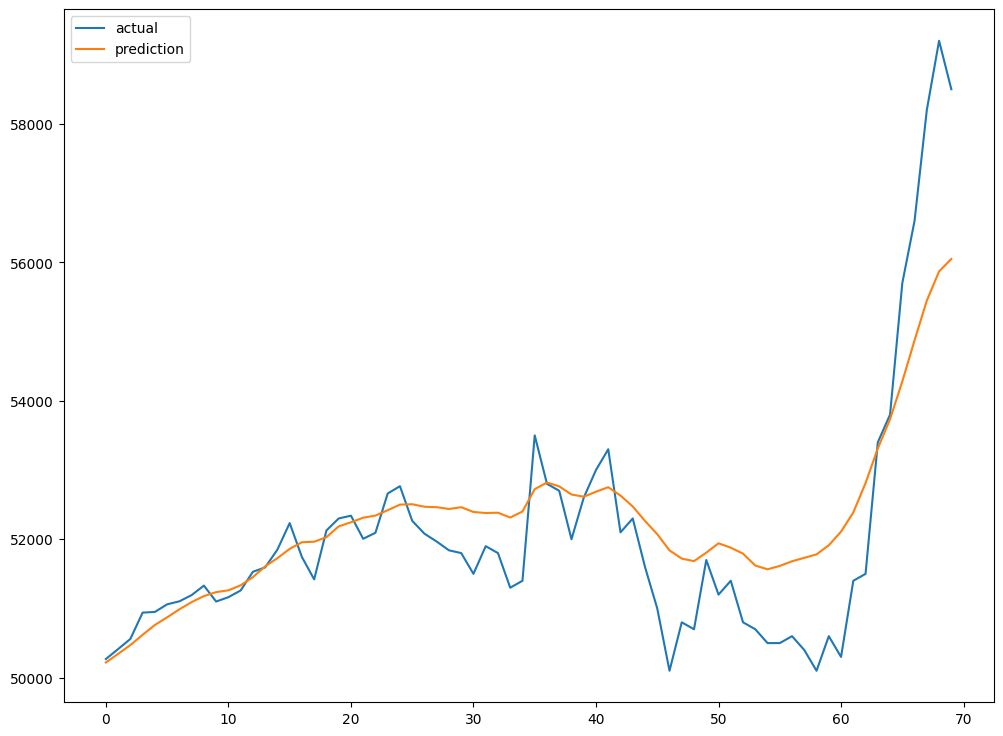

종목코드    A027410
Name: 6, dtype: object
3/3 [==============================] - 1s 16ms/step


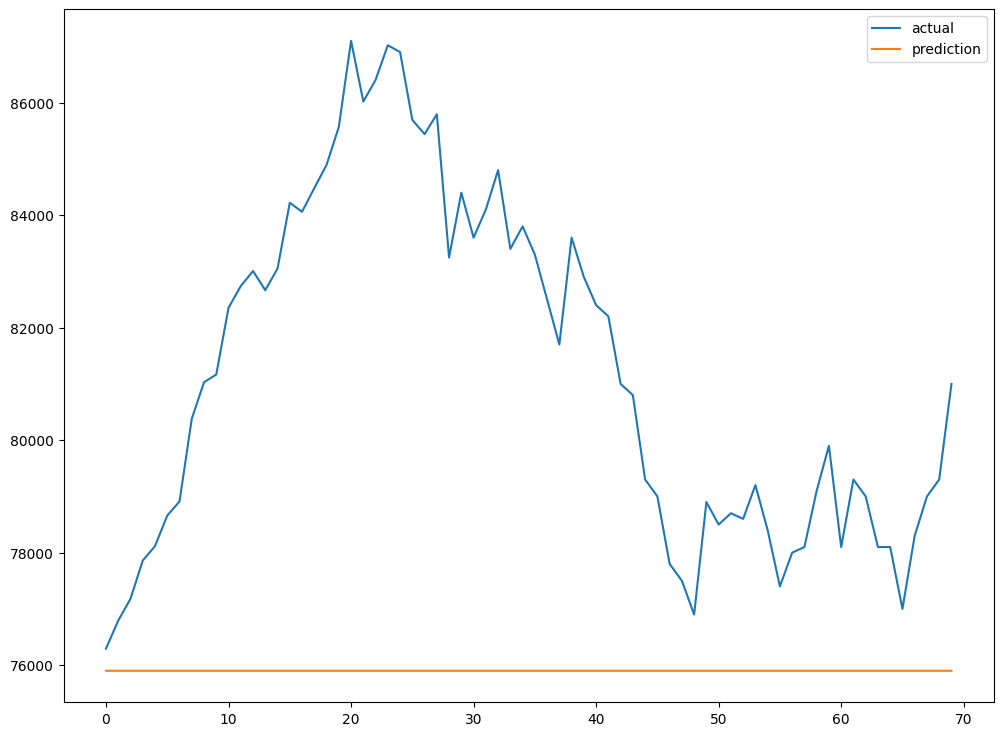

종목코드    A282330
Name: 7, dtype: object
3/3 [==============================] - 1s 16ms/step


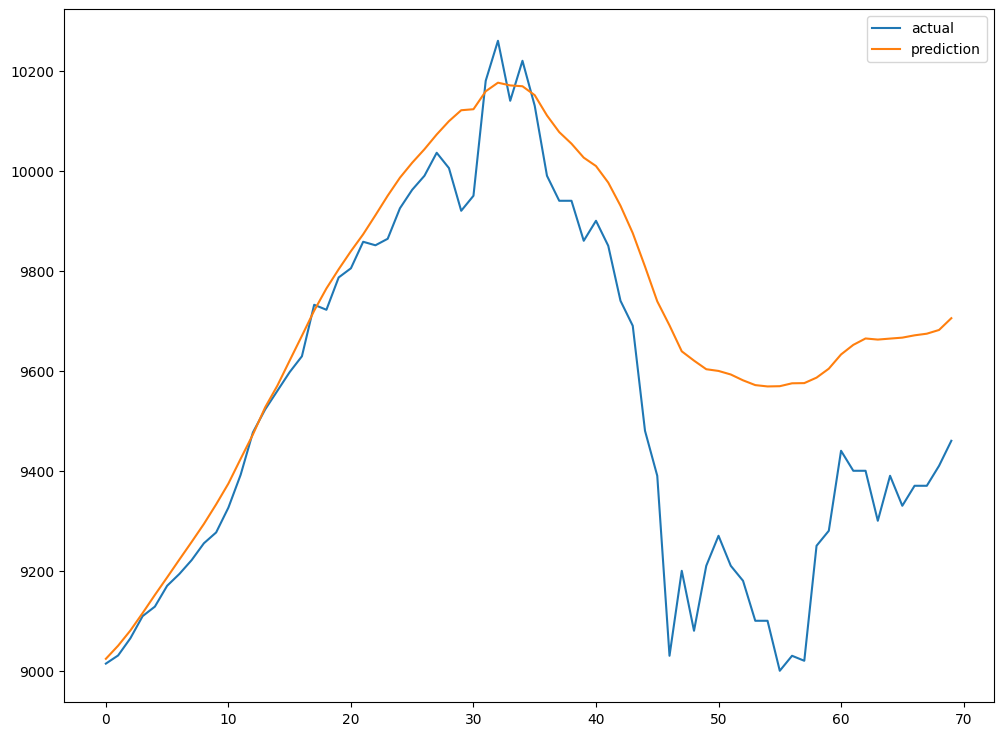

종목코드    A126600
Name: 8, dtype: object


AttributeError: ignored

In [7]:
idx=0
for c in sliced_dataframes:
  print(labels.iloc[idx])
  LSTM_model=LSTM_Object(c)
  LSTM_model.ret_learning()
  idx+=1
  sleep(5)
  #to prevent model corrupting

In [ ]:
labels.info

In [ ]:
labels.iloc[0]